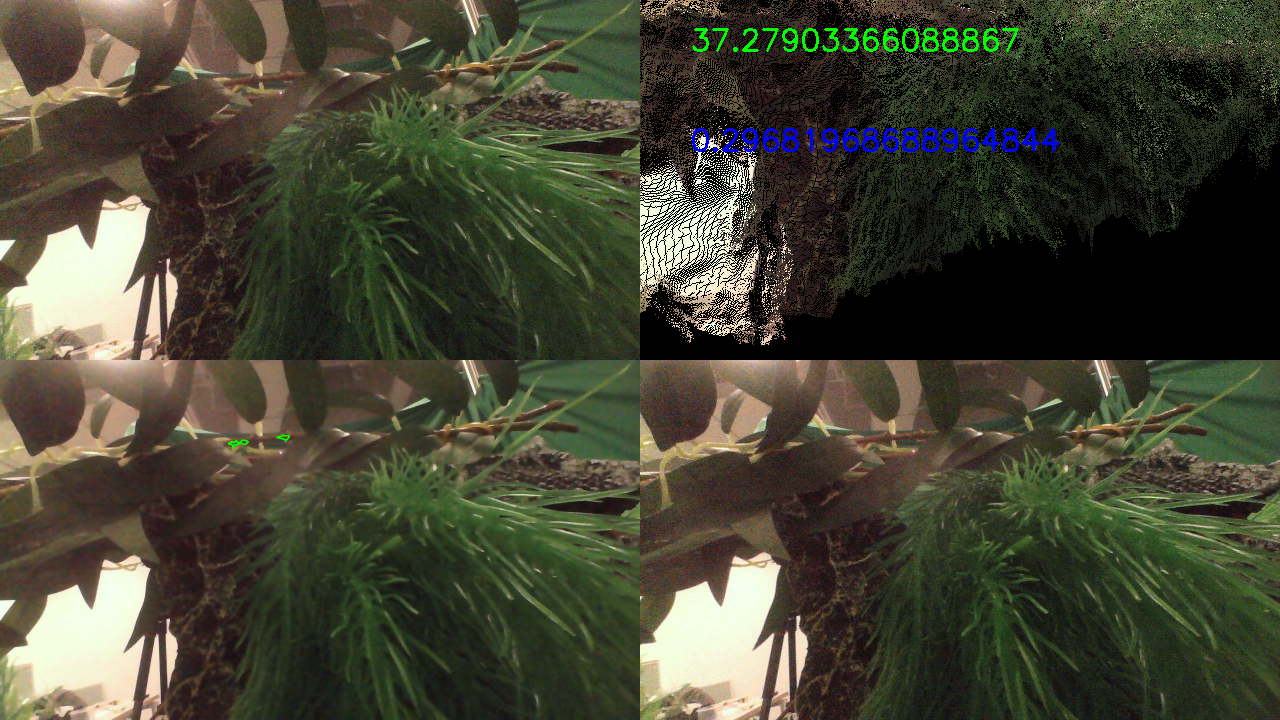

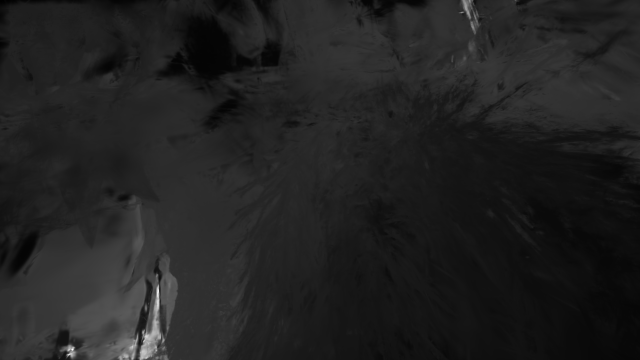

KeyboardInterrupt: 

In [75]:
import os
import cv2
import numpy as np
from scipy.spatial.transform import Rotation as R
import sys
from matplotlib import pyplot as plt
from IPython.display import display, clear_output
import time
import pdb
import lpips
from PIL import Image

def detect_red(image_path):
    # Load the image
    image = cv2.imread(image_path)

    image = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)

    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the lower and upper bounds for red color in HSV
    lower_red = np.array([0, 130, 56])
    upper_red = np.array([10, 255, 255])

    # Create a mask for red regions
    red_mask = cv2.inRange(hsv_image, lower_red, upper_red)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    red_mask = cv2.morphologyEx(red_mask, cv2.MORPH_CLOSE, kernel)

    # Find contours in the mask
    contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_sum = 0

    contours_filter = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 100:
            contour_sum+=area 
            contours_filter.append(contour)
        #print(f"Contour Area: {area}")

    # Draw contours on the original image
    result_image = image.copy()
    cv2.drawContours(result_image, contours_filter, -1, (0, 255, 0), 2)

    return red_mask, contour_sum, result_image

def split_list(input_list, chunk_size = 18):
    return [input_list[i:i+chunk_size] for i in range(0, len(input_list), chunk_size)]


def get_rt(txt_dir,target_name):
    img_txt = os.path.join(txt_dir,'images.txt')
    cam_txt = os.path.join(txt_dir, 'cameras.txt')
    with open(img_txt,'r') as f:
        ll = f.readlines()
    ll = ll[4:]

    ll = ll[::2]
    target_name = os.path.basename(target_name)
    target_name = target_name.replace('images_','')
    target_name = target_name[:-4]
    # target_name = target_name.split('.')[-2]
    for l in ll:
        cont = l.split()
        cam_name = os.path.basename(cont[9])
        cam_name = cam_name[:-4]
        if target_name == cam_name:
            #print(cam_name)
            rt = cont
            cam_ind = int(cont[8])
            break
    
    cam_name = os.path.basename(rt[9]).split('.')[0]

    #QW, QX, QY, QZ = [float(rt[1]), float(rt[2]),  float(rt[3]),  float(rt[4])]
    Rq1 = np.asarray([float(rt[2]),  float(rt[3]),  float(rt[4]), float(rt[1])])
    r1 = R.from_quat(Rq1)
    Rm1 = r1.as_matrix()
    T = np.asarray([float(rt[5]), float(rt[6]), float(rt[7])])

    with open(cam_txt,'r') as f:
        ll = f.readlines()
        ll = ll[3:]
    K = ll[cam_ind - 1]
    K = K.split()[4:]
    K = [float(i) for i in K]
    return Rm1, T, K

def relative_pose(R_view1, T_view1, R_view2, T_view2):

    # 计算相对位置变换
    R_relative = np.dot(R_view2, np.linalg.inv(R_view1))
    #T_relative = T_view2 - np.dot(R_view2, T_view1)
    T_relative = T_view2 - np.dot(R_view2, T_view1)
    # 构造相对位置变换矩阵
    relative_transform = np.identity(4)
    relative_transform[:3, :3] = R_relative
    relative_transform[:3, 3] = T_relative
    return relative_transform

def project_depth_rgb(K1,K2,relative_transform,depth_image_A,rgb_A = None):
    # 视角B相对于视角A的姿态变换矩阵
    pose_A_to_B = np.array(relative_transform)  # 4x4姿态矩阵

    fx,fy,cx,cy = K1

    camera_matrix_A = np.array([[fx, 0, cx],
                                [0, fy, cy],
                                [0, 0, 1]])
    # 视角B相对于视角A的姿态变换矩阵
    pose_A_to_B = np.array(relative_transform)  # 4x4姿态矩阵
    # 视角B相机内参
    fx2,fy2,cx2,cy2 = K2
    camera_matrix_B = np.array([[fx2, 0, cx2],
                                [0, fy2, cy2],
                                [0, 0, 1]])

    # 获取视角A图像的高度和宽度
    height_A, width_A = depth_image_A.shape[:2]

    # 创建视角B的空白RGB和深度图像
    if rgb_A is not None:
        rgb_image_B = np.zeros((height_A, width_A, 3), dtype=np.uint8)
    depth_image_B = np.zeros((height_A, width_A), dtype=np.float32)

    # 遍历视角A的每个像素
    for y in range(height_A):
        for x in range(width_A):
            # 获取视角A中的深度信息
            depth_A = depth_image_A[y, x]
            #print(depth_A)
            if depth_A > 0:
                # 计算视角A中像素的3D坐标
                #depth_A *= 0.1
                point_A = np.array([(x - cx) * depth_A / fx,
                                    (y - cy) * depth_A / fy,
                                    depth_A,1])

                point_B = np.dot(pose_A_to_B, point_A)
                # 将3D点从视角B坐标系投影回视角B图像平面
                u_B = int(point_B[0] * fx2 / point_B[2] + cx2)
                v_B = int(point_B[1] * fy2 / point_B[2] + cy2)

                if 0 <= u_B < width_A and 0 <= v_B < height_A:
                    depth_image_B[v_B, u_B] = depth_A
                    if rgb_A is not None:
                        rgb_image_B[v_B, u_B,:] = rgb_A[y, x,:]
    return depth_image_B, rgb_image_B

def project_pipeline(txt_dir, img, img2, dep, dep2):
    R1, T1, K1 = get_rt(txt_dir, img)
    R2, T2, K2 = get_rt(txt_dir, img2)

    relative_transform = relative_pose(R1, T1, R2, T2)

    depth_image_A = np.load(dep)
    rgb_A = cv2.imread(img)
    K1 = [k / 2 for k in K1]
    K2 = [k / 2 for k in K2]
    height, width = rgb_A.shape[:2]
    rgb_A = cv2.resize(rgb_A, (width // 2, height // 2))
    depth_image_A = cv2.resize(depth_image_A, (width // 2, height // 2))
    
    #T1 = time.perf_counter()
    depth_image_B,rgb_B = project_depth_rgb(K1, K2,relative_transform, depth_image_A, rgb_A)
    #T2 = time.perf_counter()
    
    rgb_B_gt = cv2.imread(img2)
    rgb_B_gt = cv2.resize(rgb_B_gt,(width // 2, height // 2))

    mask = np.ones_like(depth_image_B)
    mask_zeros = mask.size - np.count_nonzero(mask)
    mask[depth_image_B == 0] = 0
    mask_3 = np.stack((mask,mask,mask),2)

    img0 = lpips.im2tensor(rgb_B_gt*mask_3) # RGB image from [-1,1]
    img1 = lpips.im2tensor(rgb_B)
    # Compute distance lpips
    dist = loss_fn.forward(img0, img1).squeeze().item()
    
    rgb_B_ = rgb_B.astype(np.float32)
    rgb_B_gt_ = rgb_B_gt.astype(np.float32)
    mse = np.sum(np.abs(rgb_B_ - rgb_B_gt_*mask_3)) / np.sum(mask_3)
    return rgb_A, depth_image_A, rgb_B, depth_image_B, rgb_B_gt, mse, dist, mask_zeros



if __name__ == '__main__':
    temp_dir = '/data/jianing/dlf_depth_test'
    os.makedirs(temp_dir, exist_ok=True)
    root = '/data/jianing/output_829/colmap_1_1'

    train_depth_dir = os.path.join(root,'train','ours_10000','depth')
    test_depth_dir = os.path.join(root,'test','ours_10000','depth')

    train_img_dir = os.path.join(root,'train','ours_10000','gt')
    test_img_dir = os.path.join(root,'test','ours_10000','gt')

    ll_img_ref = [os.path.join(train_img_dir,i) for i in os.listdir(train_img_dir)]
    ll_img_test = [os.path.join(test_img_dir,i) for i in os.listdir(test_img_dir)]
    ll_dep_ref = [os.path.join(train_depth_dir,i) for i in os.listdir(train_depth_dir) if '.npy' in i]
    ll_dep_test = [os.path.join(test_depth_dir,i) for i in os.listdir(test_depth_dir) if '.npy' in i]

    ll_img_ref = sorted(ll_img_ref)
    ll_img_test = sorted(ll_img_test)
    ll_dep_ref = sorted(ll_dep_ref)
    ll_dep_test = sorted(ll_dep_test)

    txt_dir = '/data/jianing/dlf_result/proj_0829_all/sparse/0'
    loss_fn = lpips.LPIPS(net='alex',version='0.1')

    ll_img_ref = split_list(ll_img_ref)
    ll_img_test = split_list(ll_img_test)[3:]
    ll_dep_ref = split_list(ll_dep_ref)
    ll_dep_test = split_list(ll_dep_test)[3:]
    
    for img_list_render, dep_list_render in zip(ll_img_test, ll_dep_test):
        for img_list, dep_list in zip(ll_img_ref,ll_dep_ref):
            for img, dep, img_render, dep_render in zip(img_list,dep_list,img_list_render,dep_list_render):
                
                rgb_A, depth_image_A, rgb_B, depth_image_B, rgb_B_gt, mse, dist, mask_zeros = project_pipeline(txt_dir, img_render, img, dep_render, dep)
                red_mask, contour_sum, red_result = detect_red(img_render)
                
                rgb_B = cv2.putText(rgb_B, f'{mse}', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                rgb_B = cv2.putText(rgb_B, f'{dist}', (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
                
                height, width = rgb_A.shape[:2]
                red_result = cv2.resize(red_result, (width, height))
                
                if contour_sum > 100:
                    result1 = cv2.hconcat([rgb_A, rgb_B])
                    result2 = cv2.hconcat([red_result,rgb_B_gt])
                    result = cv2.vconcat([result1, result2])
                else:
                    result = cv2.vconcat([rgb_A, rgb_B,rgb_B_gt])
                result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
                normalized_depth = cv2.normalize(depth_image_A, None, 0, 255, cv2.NORM_MINMAX)
                depth_gray = np.uint8(normalized_depth)

                clear_output(wait=True)
                display(Image.fromarray(result, mode='RGB'))
                display(Image.fromarray(depth_gray, mode='L'))
                
                # # 等待一段时间
                time.sleep(0.5)